<center><h2>ALTEGRAD Project</h2>

<hr>
<span style="font-variant: small-caps;">Xavier Jiménez, Jean Quentin, Sacha Revol</span><br>
<hr>
</center>

In [1]:
import numpy as np
import gdown
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn import preprocessing
import csv

# Download datasets

In [2]:
# Download X_train 
# If permission error try upgrading gdown: pip install --upgrade --no-cache-dir gdown
url = "https://drive.google.com/file/d/1zpKbkD4zO6bngItVxkaPZrqpRisqRXco/view?usp=sharing"
output = "X_train.npy"
gdown.download(url, output, quiet=True, fuzzy=True)

'X_train.npy'

In [19]:
# Download X_test
url = "https://drive.google.com/file/d/1ONZIRdbv_tHmUQNmUGqXhPqBr5Ltnn6S/view?usp=sharing"
output = "X_test.npy"
gdown.download(url, output, quiet=True, fuzzy=True)

'X_test.npy'

In [20]:
# Download X_train_val
url = "https://drive.google.com/file/d/104dhE4QAsbVUmEvsFB4YA83uvkZKigy_/view?usp=sharing"
output = "X_train_val.npy"
gdown.download(url, output, quiet=True, fuzzy=True)

'X_train_val.npy'

In [21]:
# Download X_val
url = "https://drive.google.com/file/d/1RtLtIwFla1o0BYZpyRQVN7XgpxMgMX4T/view?usp=sharing"
output = "X_val.npy"
gdown.download(url, output, quiet=True, fuzzy=True)

'X_val.npy'

In [22]:
# Download y_train
url = "https://drive.google.com/file/d/12vgW5iD9lNm98mmhnK0QLagbV1gvBgQO/view?usp=sharing"
output = "y_train.npy"
gdown.download(url, output, quiet=True, fuzzy=True)

'y_train.npy'

In [23]:
# Download y_train_val
url = "https://drive.google.com/file/d/19vNXtxIxOTbmVAsVl4zSEbWs8emz_aVo/view?usp=sharing"
output = "y_train_val.npy"
gdown.download(url, output, quiet=True, fuzzy=True)

'y_train_val.npy'

In [24]:
# Download y_val
url = "https://drive.google.com/file/d/1-Xe9a4T7jkfyYt2L5fUUWYly93ODig8L/view?usp=sharing"
output = "y_val.npy"
gdown.download(url, output, quiet=True, fuzzy=True)

'y_val.npy'

# Predictions

In [4]:
def load_matrix(validation = True):
    if validation:
        y_train = np.load('y_train_val.npy')
        X_train = np.load('X_train_val.npy')
        X_val = np.load('X_val.npy')
        y_val = np.load('y_val.npy')
        return X_train.astype(np.float64), X_val.astype(np.float64), y_train.astype(np.float64), y_val.astype(np.float64)
    else:
        y_train = np.load('y_train.npy')
        X_train = np.load('X_train.npy')
        X_test = np.load('X_test.npy')
        return X_train.astype(np.float64), X_test.astype(np.float64), y_train.astype(np.float64)
    
def train(X_train, X_test, y_train, y_test = None, normalize = True, model = LogisticRegression(max_iter = 300)):
    if normalize:
        scaler = preprocessing.StandardScaler().fit(X_train)

        X_train = scaler.transform(X_train)
        X_test = scaler.fit_transform(X_test)
    
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)
    y_pred = y_pred[:,1]
    if y_test is not None:
        print('Validation loss = {:.4f}'.format(log_loss(y_test, y_pred)))
    else:
        # Write predictions to a file
        print('Creating submission')
        predictions = zip(range(len(y_pred)), y_pred)
        # os.remove("data/submission.csv")
        with open("submission.csv","w") as pred:
            csv_out = csv.writer(pred)
            csv_out.writerow(['id','predicted'])
            for row in predictions:
                csv_out.writerow(row)
        print('Submision created')
    return y_pred, model

## Validation scores

### CatBoost

In [26]:
from catboost import CatBoostClassifier

X_train, X_val, y_train, y_val = load_matrix(validation = True)
catboost_best_params = {'border_count': 125.0398324059968, 'depth': 4.0, 'l2_leaf_reg': 7.091575748470791, 'learning_rate': 0.02196998307042895}
y_pred_cb, model_cb = train(X_train, X_val, y_train, y_val, normalize = False, model = CatBoostClassifier(iterations=10000,
                                                                                                        learning_rate=catboost_best_params['learning_rate'],
                                                                                                        depth=int(catboost_best_params['depth']),
                                                                                                        loss_function='Logloss',
                                                                                                        task_type="GPU",
                                                                                                        eval_metric='Logloss',
                                                                                                        l2_leaf_reg=catboost_best_params['l2_leaf_reg'],
                                                                                                        early_stopping_rounds=3000,
                                                                                                        od_type="Iter",
                                                                                                        border_count=int(catboost_best_params['border_count']),
                                                                                                        verbose=False
                                                                                                        ))


Validation loss = 0.0842


### XGBoost

In [27]:
from xgboost import XGBClassifier

X_train, X_val, y_train, y_val = load_matrix(validation = True)
xgb_best_params = {'colsample_bytree': 0.5, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 5, 'subsample': 0.9903964909697581, 'n_estimators': 400}
y_pred_xgb, model_xgb = train(X_train, X_val, y_train, y_val, normalize = False, model = XGBClassifier(**xgb_best_params, tree_method='gpu_hist', gpu_id=0, use_label_encoder=False))

[09:13:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Validation loss = 0.0849


### LightGBM

In [28]:
from lightgbm import LGBMClassifier

X_train, X_val, y_train, y_val = load_matrix(validation = True)

lgbm_best_params = {'colsample_bytree': 0.4289902005468654, 'max_depth': 7, 'min_child_weight': 7,  'n_estimators': 500, 'learning_rate':0.1,
  'min_split_gain': 0.8237097093914703, 'num_leaves': 78, 'reg_alpha': 0.4619815836877414, 'reg_lambda': 0.3702649278033648, 'subsample': 0.838062378418677}
y_pred_lgbm, model_lgbm = train(X_train, X_val, y_train, y_val, normalize = False, model = LGBMClassifier(**lgbm_best_params, n_jobs=2))

Validation loss = 0.0848


### Stacking

In [29]:
y_average = np.mean([y_pred_lgbm, y_pred_cb], axis = 0)
log_loss(y_val, y_average)

0.08396529797651957

## Submissions

### LightGBM

In [5]:
from lightgbm import LGBMClassifier

lgbm_best_params = {'colsample_bytree': 0.4289902005468654, 'max_depth': 7, 'min_child_weight': 7,  'n_estimators': 500, 'learning_rate':0.1,
  'min_split_gain': 0.8237097093914703, 'num_leaves': 78, 'reg_alpha': 0.4619815836877414, 'reg_lambda': 0.3702649278033648, 'subsample': 0.838062378418677}
X_train, X_test, y_train = load_matrix(validation = False)
y_pred_lgbm, model_lgbm = train(X_train, X_test, y_train, None, normalize = False, model = LGBMClassifier(**lgbm_best_params, n_jobs=6))

Creating submission
Submision created


### XGBoost

In [6]:
from xgboost import XGBClassifier

xgb_best_params = {'colsample_bytree': 0.5, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 5, 'subsample': 0.9903964909697581, 'n_estimators': 400}
X_train, X_test, y_train = load_matrix(validation = False)
y_pred_xgb, model_xgb = train(X_train, X_test, y_train, None, normalize = False, model = XGBClassifier(**xgb_best_params, tree_method='gpu_hist', gpu_id=0, use_label_encoder=False))


[09:21:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Creating submission
Submision created


### CatBoost

In [7]:
from catboost import CatBoostClassifier

catboost_best_params = {'border_count': 125.0398324059968, 'depth': 4.0, 'l2_leaf_reg': 7.091575748470791, 'learning_rate': 0.02196998307042895}
X_train, X_test, y_train = load_matrix(validation = False)
y_pred_cb, model_cb = train(X_train, X_test, y_train, None, normalize = False, model = CatBoostClassifier(iterations=10000,
                                                                                                        learning_rate=catboost_best_params['learning_rate'],
                                                                                                        depth=int(catboost_best_params['depth']),
                                                                                                        loss_function='Logloss',
                                                                                                        task_type="GPU",
                                                                                                        eval_metric='Logloss',
                                                                                                        l2_leaf_reg=catboost_best_params['l2_leaf_reg'],
                                                                                                        early_stopping_rounds=3000,
                                                                                                        od_type="Iter",
                                                                                                        border_count=int(catboost_best_params['border_count']),
                                                                                                        verbose=False
                                                                                                        ))

Creating submission
Submision created


### Stacking

In [9]:
y_average = np.mean([y_pred_lgbm, y_pred_cb], axis = 0)

predictions = zip(range(len(y_average)), y_average)
with open("submission_average.csv","w") as pred:
    csv_out = csv.writer(pred)
    csv_out.writerow(['id','predicted'])
    for row in predictions:
        csv_out.writerow(row)

## SHAP

In [10]:
feature_names = [
    '(S) Abstract size', '(D) Abstract size', 'Words in common', '(S) Degree', '(D) Degree', 'Authors in common', '(S) Avg deg connectivity', 
    '(D) Avg deg connectivity', '(S) Avg neigh deg', '(D) Avg neigh deg', '(S) Pagerank', '(D) Pagerank', '(S) Eig centrality', '(D) Eig centrality', '(S) Greedy color', 
    '(D) Greedy color', '(S) Triangles', '(D) Triangles', '(S) Core number', '(D) Core number', '(S) Onion number', '(D) Onion number', '(S) Degree centrality', 
    '(D) Degree centrality', '(S) Clustering', '(D) Clustering', 'Sentence Transformer', 'Co-authors N2V','Doc2Vec', 'N2V Citation Graph', 'Walklets Citation Graph', 'N2V Authors Citation G.', 
    'Salton index', 'Academic Adar Index', 'Jaccard Coefficient', 'Pref Attachment', 'Shortest Path', 'Hub Depressed Index', 'Ressource Allocation Index'
]

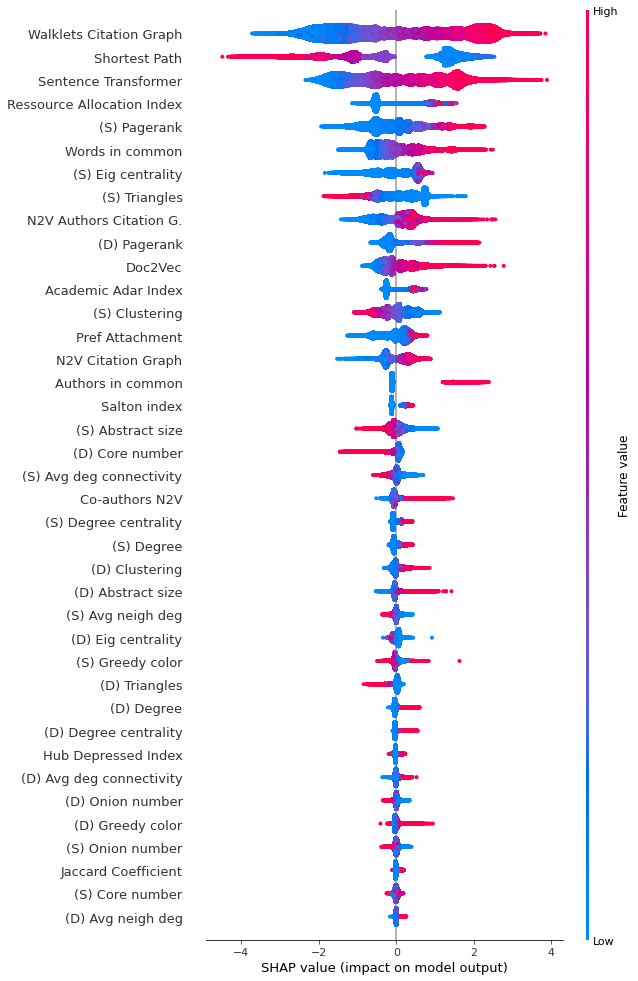

In [11]:
import shap
shap_values = shap.TreeExplainer(model_cb).shap_values(X_train)
shap.summary_plot(shap_values, X_train, max_display=X_train.shape[1], feature_names = feature_names)